In [ ]:
!pip3 install sympy
!pip3 install iminuit

In [1]:
# All import lines
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats
from scipy.optimize import curve_fit, minimize
import sympy as sym
from sympy.functions import exp
from sympy import symbols, diff
from numpy.linalg import inv
from iminuit import Minuit
from iminuit.cost import LeastSquares
import sympy as sym
from sympy.functions import exp
from sympy import symbols, diff


def fortran_to_py(string):
    str_1 = string.replace('\n     -','').replace('\t','').replace('\r','').replace('\n','')
    str_2 = str_1.replace('\\','')
    str_3 = str_2.replace('Sqrt','np.sqrt').replace('lambda','lamda').replace('^','**')
    str_4 = str_3
    while '  ' in str_4:
        str_4 = str_4.replace('  ',' ')
    return str_4


def fortran_to_wolfram(string):
    str_1 = string.replace('\n     -','').replace('\t','').replace('\r','')
    str_2 = str_1.replace('\\','')
    str_3 = str_2.replace('Sqrt','np.sqrt').replace('lambda','1')
    str_4 = str_3
    while '  ' in str_4:
        str_4 = str_4.replace('  ',' ')
    str_5=str_4.replace('**','^')
    return str_5


def grad(f,val_list,Q2,k_max):
    """finds gradient of a function f...works for usual operators and exp
       inputs: f, function
               var_list: list of variable symbols as strings, length N
               val_list: list of values (one for each variable) which the gradient is to be evaluated at, length N
               Q2: Q^2 value at which the gradient is to be evaluated, float
               k_max: k_max of the z expansion from https://doi.org/10.1103/PhysRevD.93.113015, int>4
        returns: list of gradient w.r.t. variables in var_list at the point x=x_val, length N
        """
    dZ_dQ2 = np.sqrt(t_cut-t_0)/(np.sqrt(t_cut+Q2)*(np.sqrt(t_cut-t_0)+np.sqrt(t_cut+Q2))**2)
    z_val = (np.sqrt(t_cut+Q2)-np.sqrt(t_cut-t_0))/(np.sqrt(t_cut+Q2)+np.sqrt(t_cut-t_0))

    f_string=str(f).replace('^', '**')
    if k_max==5:
        a1, z = symbols('a1 z', real=True)
        var_list=[a1]
    elif k_max==6:
        a1, a2, z = symbols('a1 a2 z', real=True)
        var_list=[a1,a2]
    elif k_max==7:
        a1, a2, a3, z = symbols('a1 a2 a3 z', real=True)
        var_list=[a1,a2,a3]
    elif k_max==8:
        a1, a2, a3, a4, z = symbols('a1 a2 a3 a4 z', real=True)
        var_list=[a1,a2,a3,a4]
    elif k_max==9:
        a1, a2, a3, a4, a5, z = symbols('a1 a2 a3 a4 a5 z', real=True)
        var_list=[a1,a2,a3,a4,a5]
    elif k_max==10:
        a1, a2, a3, a4, a5, a6, z = symbols('a1 a2 a3 a4 a5 a6 z', real=True)
        var_list=[a1,a2,a3,a4,a5,a6]
    elif k_max>10:
        print('larger expansion than accommodated for')

    f_no_np=eval(f_string)
    var_gradient=[]
    for var in var_list:
        partial=diff(f_no_np,var)
        partial_string=str(partial)
        partial_string_nums=partial_string
        #put in values for variables from val_list
        for i in range(len(var_list)):
            partial_string_nums=partial_string_nums.replace(str(var_list[i]),'('+str(var_list[i])+')').replace('('+str(var_list[i])+')',str(val_list[i]))
        #put in value for z from z_val
        partial_string_nums=partial_string_nums.replace('z','(z)').replace('z',str(z_val))
        partial_val=eval(partial_string_nums)*dZ_dQ2
        var_gradient.append(partial_val)
    var_gradient = np.array(var_gradient)

    return var_gradient

In [2]:
FA0 = -1.2723

FA_data_file='form_factor_data/Fa_BBBA07_Orig.csv'
FA_data=pd.read_csv(FA_data_file)
FA_cov_file='form_factor_data/Cov_BBBA07_Orig.csv'
FA_cov_matrix=pd.read_csv(FA_cov_file)
FA_cov_matrix_scaled=np.array(FA_cov_matrix)[2:17, 3:18]/(FA0**2)
Q2_vals=FA_data['Q2'][3:18]
FA_scaled=FA_data['Fa'][3:18]/FA0
FA_err_scaled=np.sqrt(np.diag(FA_cov_matrix_scaled))

lamda=1

t_cut = 0.1753195965819489002

In [3]:
def findZ(t_cut,t_0,Q2):
    '''computes z(Q2) for given paramaters
       inputs: t_cut - fixed t_cut=9*(m_pion/(GeV/c^2))^2 paramater from https://doi.org/10.1103/PhysRevD.93.113015, float
               t_0 - variable t_0 paramater from https://doi.org/10.1103/PhysRevD.93.113015, float
               Q2 - Q^2 value(s) at which to evaluate z, float or array-like
       returns: z - z value(s) for these parameters, float or array-like'''
    z_str_fortran = '''(Sqrt(t_cut+Q2)-Sqrt(t_cut-t_0))/(Sqrt(t_cut+Q2)+Sqrt(t_cut-t_0))'''
    z_str = fortran_to_py(z_str_fortran)
    z = eval(z_str)
    return z

def zExp_of_z(zExp_str_fortran,z,k_max,params):
    '''computes z-expansion FA(z)
       inputs: zExp_str_fortran - Fortran form of the z expansion, string
               z - z value(s) at which to evaluate FA, float or array-like
               k_max - k_max of the z expansion from https://doi.org/10.1103/PhysRevD.93.113015, int>4
               params - values for a_i paramaters, array-like
       returns: zExp - FA value(s), float or array-like'''
    #changes for different k_max
    if k_max==5:
        a1 = params
    elif k_max==6:
        a1, a2 = params
    elif k_max==7:
        a1, a2, a3 = params
    elif k_max==8:
        a1, a2, a3, a4 = params
    elif k_max==9:
        a1, a2, a3, a4, a5 = params
    elif k_max==10:
        a1, a2, a3, a4, a5, a6 = params
    elif k_max>10:
        print('larger expansion than accommodated for')
    zExp_str = fortran_to_py(zExp_str_fortran)
    zExp = eval(zExp_str)
    return zExp

#change inputs for different values of k_max
def getPenalty(penalty_str_fortran,k_max,param_list):
    '''finds chi-squared penalty from excess terms
       inputs: k_max - k_max of the z expansion from https://doi.org/10.1103/PhysRevD.93.113015, int>4
               penalty_str_fortran - Fortran form of the penalty function, string
               param_list - list of fit paramaters, array-like
       returns: penalty - chi-squared penalty from excess terms, float'''
    penalty_str = fortran_to_py(penalty_str_fortran)
    if k_max==5:
        a1 = param_list
    elif k_max==6:
        a1, a2 = param_list
    elif k_max==7:
        a1, a2, a3 = param_list
    elif k_max==8:
        a1, a2, a3, a4 = param_list
    elif k_max==9:
        a1, a2, a3, a4, a5 = param_list
    elif k_max==10:
        a1, a2, a3, a4, a5, a6 = param_list
    elif k_max>10:
        print('larger expansion than accommodated for')
    penalty = eval(penalty_str)
    return penalty

#change inputs for different values of k_max
def FAchiSq05(a1):
    '''finds chi^2 value, with penalty
       inputs: a1,... - k_max-4 free fit parameters for the z expansion, floats
       returns: chi2 - chi^2 value for the fit'''
    z_vals = findZ(t_cut,t_0,Q2_vals)
    FA_cov_inverse = inv(FA_cov_matrix_scaled)
    # changes for different k_max values
    fit_params = [a1]
    X = FA_scaled
    Y = zExp_of_z(zExp_str_fortran,z_vals,k_max,fit_params)
    X_minus_Y = X-Y
    penalty = getPenalty(penalty_str_fortran,k_max,fit_params)
    chi2 = (np.matmul(np.matmul(X_minus_Y, FA_cov_inverse), X_minus_Y))+penalty
    return chi2

def FAchiSq06(a1,a2):
    '''finds chi^2 value, with penalty
       inputs: a1,... - k_max-4 free fit parameters for the z expansion, floats
       returns: chi2 - chi^2 value for the fit'''
    z_vals = findZ(t_cut,t_0,Q2_vals)
    FA_cov_inverse = inv(FA_cov_matrix_scaled)
    # changes for different k_max values
    fit_params = [a1,a2]
    X = FA_scaled
    Y = zExp_of_z(zExp_str_fortran,z_vals,k_max,fit_params)
    X_minus_Y = X-Y
    penalty = getPenalty(penalty_str_fortran,k_max,fit_params)
    chi2 = (np.matmul(np.matmul(X_minus_Y, FA_cov_inverse), X_minus_Y))+penalty
    return chi2

def FAchiSq07(a1,a2,a3):
    '''finds chi^2 value, with penalty
       inputs: a1,... - k_max-4 free fit parameters for the z expansion, floats
       returns: chi2 - chi^2 value for the fit'''
    z_vals = findZ(t_cut,t_0,Q2_vals)
    FA_cov_inverse = inv(FA_cov_matrix_scaled)
    # changes for different k_max values
    fit_params = [a1,a2,a3]
    X = FA_scaled
    Y = zExp_of_z(zExp_str_fortran,z_vals,k_max,fit_params)
    X_minus_Y = X-Y
    penalty = getPenalty(penalty_str_fortran,k_max,fit_params)
    chi2 = (np.matmul(np.matmul(X_minus_Y, FA_cov_inverse), X_minus_Y))+penalty
    return chi2

def FAchiSq08(a1,a2,a3,a4):
    '''finds chi^2 value, with penalty
       inputs: a1,... - k_max-4 free fit parameters for the z expansion, floats
       returns: chi2 - chi^2 value for the fit'''
    z_vals = findZ(t_cut,t_0,Q2_vals)
    FA_cov_inverse = inv(FA_cov_matrix_scaled)
    # changes for different k_max values
    fit_params = [a1,a2,a3,a4]
    X = FA_scaled
    Y = zExp_of_z(zExp_str_fortran,z_vals,k_max,fit_params)
    X_minus_Y = X-Y
    penalty = getPenalty(penalty_str_fortran,k_max,fit_params)
    chi2 = (np.matmul(np.matmul(X_minus_Y, FA_cov_inverse), X_minus_Y))+penalty
    return chi2

def FAchiSq09(a1,a2,a3,a4,a5):
    '''finds chi^2 value, with penalty
       inputs: a1,... - k_max-4 free fit parameters for the z expansion, floats
       returns: chi2 - chi^2 value for the fit'''
    z_vals = findZ(t_cut,t_0,Q2_vals)
    FA_cov_inverse = inv(FA_cov_matrix_scaled)
    # changes for different k_max values
    fit_params = [a1,a2,a3,a4,a5]
    X = FA_scaled
    Y = zExp_of_z(zExp_str_fortran,z_vals,k_max,fit_params)
    X_minus_Y = X-Y
    penalty = getPenalty(penalty_str_fortran,k_max,fit_params)
    chi2 = (np.matmul(np.matmul(X_minus_Y, FA_cov_inverse), X_minus_Y))+penalty
    return chi2

def FAchiSq10(a1,a2,a3,a4,a5,a6):
    '''finds chi^2 value, with penalty
       inputs: a1,... - k_max-4 free fit parameters for the z expansion, floats
       returns: chi2 - chi^2 value for the fit'''
    z_vals = findZ(t_cut,t_0,Q2_vals)
    FA_cov_inverse = inv(FA_cov_matrix_scaled)
    # changes for different k_max values
    fit_params = [a1,a2,a3,a4,a5,a6]
    X = FA_scaled
    Y = zExp_of_z(zExp_str_fortran,z_vals,k_max,fit_params)
    X_minus_Y = X-Y
    penalty = getPenalty(penalty_str_fortran,k_max,fit_params)
    chi2 = (np.matmul(np.matmul(X_minus_Y, FA_cov_inverse), X_minus_Y))+penalty
    return chi2

In [4]:
zExp_str_fortran = '''-0.7859781498074354*
     -  (-0.4339377937135097 -
     -    0.2550396583861828*a1 -
     -    0.28011463312238144*a2 -
     -    0.07524677573007925*a3 -
     -    0.045728129215033365*a4 + a1*z +
     -    a2*z**2 + a3*z**3 + a4*z**4 +
     -    (24.300516447956543 -
     -       20.717779130373764*a1 -
     -       4.313580545146641*a2 -
     -       5.786180559115562*a3 -
     -       1.4392247639581315*a4)*z**5 +
     -    (-60.751291119891356 +
     -       48.294447825934405*a1 +
     -       5.783951362866602*a2 +
     -       9.465451397788906*a3 -
     -       0.4019380901046714*a4)*z**6 +
     -    (52.07253524562117 -
     -       39.395240993658064*a1 -
     -       2.3862440253142303*a2 -
     -       5.97038691239049*a3 +
     -       1.4873755058040041*a4)*z**7 +
     -    (-15.187822779972839 +
     -       11.073611956483601*a1 +
     -       0.19598784071665049*a2 +
     -       1.3663628494472262*a3 -
     -       0.6004845225261678*a4)*z**8)'''

penalty_str_fortran = '''(a1**2/(25.*(-0.4339377937135097 - 0.2550396583861828*a1 - 0.28011463312238144*a2 - 0.07524677573007925*a3 - 
     -          0.045728129215033365*a4)**2) + a2**2/
     -     (25.*(-0.4339377937135097 - 0.2550396583861828*a1 - 0.28011463312238144*a2 - 0.07524677573007925*a3 - 
     -          0.045728129215033365*a4)**2) + a3**2/
     -     (25.*(-0.4339377937135097 - 0.2550396583861828*a1 - 0.28011463312238144*a2 - 0.07524677573007925*a3 - 
     -          0.045728129215033365*a4)**2) + (24.300516447956543 - 20.717779130373764*a1 - 4.313580545146641*a2 - 
     -        5.786180559115562*a3 - 1.4392247639581315*a4)**2/
     -     (25.*(-0.4339377937135097 - 0.2550396583861828*a1 - 0.28011463312238144*a2 - 0.07524677573007925*a3 - 
     -          0.045728129215033365*a4)**2) + (64*
     -       (-15.187822779972839 + 11.073611956483601*a1 + 0.19598784071665049*a2 + 1.3663628494472262*a3 - 
     -          0.6004845225261678*a4)**2)/
     -     (625.*(-0.4339377937135097 - 0.2550396583861828*a1 - 0.28011463312238144*a2 - 0.07524677573007925*a3 - 
     -          0.045728129215033365*a4)**2) + (36*
     -       (-60.751291119891356 + 48.294447825934405*a1 + 5.783951362866602*a2 + 9.465451397788906*a3 - 
     -          0.4019380901046714*a4)**2)/
     -     (625.*(-0.4339377937135097 - 0.2550396583861828*a1 - 0.28011463312238144*a2 - 0.07524677573007925*a3 - 
     -          0.045728129215033365*a4)**2) + a4**2/
     -     (25.*(-0.4339377937135097 - 0.2550396583861828*a1 - 0.28011463312238144*a2 - 0.07524677573007925*a3 - 
     -          0.045728129215033365*a4)**2) + (49*
     -       (52.07253524562117 - 39.395240993658064*a1 - 2.3862440253142303*a2 - 5.97038691239049*a3 + 
     -          1.4873755058040041*a4)**2)/
     -     (625.*(-0.4339377937135097 - 0.2550396583861828*a1 - 0.28011463312238144*a2 - 0.07524677573007925*a3 - 
     -          0.045728129215033365*a4)**2))*lambda'''

k_max = 8
t_0 = -0.9

if k_max==5:
     FA_m = Minuit(FAchiSq05, a1=1)
elif k_max==6:
     FA_m = Minuit(FAchiSq06, a1=1,a2=0)
elif k_max==7:
     FA_m = Minuit(FAchiSq07, a1=1,a2=0,a3=0)
elif k_max==8:
     FA_m = Minuit(FAchiSq08, a1=1,a2=0,a3=0,a4=0)
elif k_max==9:
     FA_m = Minuit(FAchiSq09, a1=1,a2=0,a3=0,a4=0,a5=0)
elif k_max==10:
     FA_m = Minuit(FAchiSq10, a1=1,a2=0,a3=0,a4=0,a5=0,a6=0)
elif k_max>10:
     print('larger expansion than accommodated for')

FA_m.migrad()
FA_m.hesse()
FA_m.minos()

/home/tejinc/Programs/anaconda/anaconda2/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:71: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 9.271                      │              Nfcn = 485              │
│ EDM = 4.99e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a1   │   1.34    │   0.18    │   -0.18    │    0.19    │         │         │       │
│ 1 │ a2   │   -1.04   │   0.36    │   -0.34    │    0.37    │         │         │       │
│ 2 │ a3   │    0.3    │    1.0    │    -1.0    │    0.9     │         │         │       │
│ 3 │ a4   │    0.1    │    1.5    │    -1.5    │    1.5     │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │          a1           │          a2           │          a3           │          a4           │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -0.18   │   0.19    │   -0.34   │   0.37    │   -1.0    │    0.9    │   -1.5    │    1.5    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌────┬─────────────────────────────────────┐
│    │       a1       a2       a3       a4 │
├────┼─────────────────────────────────────┤
│ a1 │   0.0341 -0.00226   -0.169    0.191 │
│ a2 │ -0.00226    0.126  -0.0886   -0.307 │
│ a3 │   -0.169  -0.0886    0.943   -0.697 │
│ a4 │    0.191   -0.307   -0.697     2.22 │
└────┴─────────────────────────────────────┘

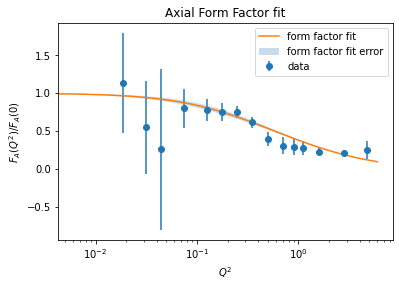

In [5]:
# draw data and fitted line
plt.errorbar(Q2_vals, FA_scaled, FA_err_scaled, fmt="o", label="data")

Q2_span = np.linspace(0, 6, 1000)
z = findZ(t_cut,t_0,Q2_span)
FA_fit = zExp_of_z(zExp_str_fortran,z,k_max,FA_m.values)
plt.plot(Q2_span, FA_fit, label="fit")
plt.xscale('log')
plt.title('Axial Form Factor fit')
plt.xlabel('$Q^2$')
plt.ylabel('$F_A(Q^2)/F_A(0)$')

fit_line_error = []
for Q2 in Q2_span:
    fit_grad = grad(fortran_to_py(zExp_str_fortran),FA_m.values,Q2,k_max)
    fit_line_error.append(np.sqrt(np.matmul(np.matmul(fit_grad, FA_m.covariance), fit_grad)))
fit_lower_bound = [(FA_fit[i]-fit_line_error[i]) for i in range(len(FA_fit))]
fit_upper_bound = [(FA_fit[i]+fit_line_error[i]) for i in range(len(FA_fit))]

plt.fill_between(Q2_span,fit_lower_bound,fit_upper_bound,alpha=0.25)

plt.legend(['form factor fit','form factor fit error','data'])

In [6]:
Gf = 1.1663787*10**(-5) # GeV^-2 *(hbar*c)^3
#M=1
M = (0.93956542052+0.93827204621)/2 # GeV /c^2
thetaC = np.arcsin(0.2245)
const = (Gf**2*(np.cos(thetaC))**2 * (M**2) )/(8*np.pi) * (1.973269788*10**(-14))**2
print(thetaC)
print('M =', M)
print(const)

0.22642990855096953
M = 0.938918733365
1.7644478781549862e-39


In [7]:
xsec_data_file='xsec_data/xsec_Orig.csv'
xsec_data=pd.read_csv(xsec_data_file)
xsec_cov_file='xsec_data/Cov_Xsec_Orig.csv'
xsec_cov_matrix=pd.read_csv(xsec_cov_file)
xsec_cov_matrix_trimmed=np.array(xsec_cov_matrix)[2:17, 3:18]
Q2_vals=xsec_data['Q2'][3:18]
xsec_trimmed=xsec_data['Xs'][3:18]
xsec_err_scaled=np.sqrt(np.diag(xsec_cov_matrix_trimmed))

In [8]:
def get_bin(binned_data,column,value):
    '''gets bin for specific value
       inputs: binned_file_name - binned data, dataframe
               column - name of column to sort by, str
               value - value to find bin for
       returns: i - index of bin'''
    if value!=0:
        dist_from_1 = []
        for val in binned_data[column]:
            dist_from_1.append(np.abs(val/value-1))
        min_ratio = np.min(np.array(dist_from_1))
        i = dist_from_1.index(min_ratio)
    elif value==0:
        i=0
    return i

def FA_to_xsec(Q2_list,FA_list):
    '''converts form factor data to cross-section
       inputs: Q2_list - Q^2 values, array-like
               FA_list - form factor values corresponding to Q^2 values, array-like
       returns: xsecs - cross-section values corresponding to Q^2 values, array-like'''
    fa0_coeffs = pd.read_csv('xsec_conversion/bbba2005_fa0.csv',names=['Q2','FA0_coeff'])
    fa1_coeffs = pd.read_csv('xsec_conversion/bbba2005_fa1.csv',names=['Q2','FA1_coeff'])
    fa2_coeffs = pd.read_csv('xsec_conversion/bbba2005_fa2.csv',names=['Q2','FA2_coeff'])

    xsecs = []
    for i in range(len(Q2_list)):
        fa0_loc = get_bin(fa0_coeffs,'Q2',Q2_list.iloc[i])
        fa0_coeff = fa0_coeffs['FA0_coeff'][fa0_loc]
        fa1_loc = get_bin(fa1_coeffs,'Q2',Q2_list.iloc[i])
        fa1_coeff = fa1_coeffs['FA1_coeff'][fa1_loc]
        fa2_loc = get_bin(fa2_coeffs,'Q2',Q2_list.iloc[i])
        fa2_coeff = fa2_coeffs['FA2_coeff'][fa2_loc]

        Gf = 1.1663787*10**(-5) # GeV^-2 *(hbar*c)^3
        #M = 1
        M = (0.93956542052+0.93827204621)/2 # GeV /c^2
        thetaC = np.arcsin(0.2245)
        const = (Gf**2*(np.cos(thetaC))**2)/(8*np.pi*M**2) * (1.973269788*10**(-14))**2

        xsec = const*(fa0_coeff+fa1_coeff*FA_list.iloc[i]+fa2_coeff*FA_list.iloc[i]**2)
        xsecs.append(xsec)
    return np.array(xsecs)

def XsecchiSq05(a1):
    '''finds chi^2 value, with penalty
       inputs: a1,... - k_max-4 free fit parameters for the z expansion, floats
       returns: chi2 - chi^2 value for the fit'''
    z_vals = findZ(t_cut,t_0,Q2_vals)
    xsec_cov_inverse = inv(xsec_cov_matrix_trimmed)
    # changes for different k_max values
    fit_params = [a1]
    X = xsec_trimmed
    FA = zExp_of_z(zExp_str_fortran,z_vals,k_max,fit_params)
    Y = FA_to_xsec(Q2_vals,FA)
    X_minus_Y = X-Y
    penalty = getPenalty(penalty_str_fortran,k_max,fit_params)
    chi2 = (np.matmul(np.matmul(X_minus_Y, xsec_cov_inverse), X_minus_Y))+penalty
    return chi2

def XsecchiSq06(a1,a2):
    '''finds chi^2 value, with penalty
       inputs: a1,... - k_max-4 free fit parameters for the z expansion, floats
       returns: chi2 - chi^2 value for the fit'''
    z_vals = findZ(t_cut,t_0,Q2_vals)
    xsec_cov_inverse = inv(xsec_cov_matrix_trimmed)
    # changes for different k_max values
    fit_params = [a1,a2]
    X = xsec_trimmed
    FA = zExp_of_z(zExp_str_fortran,z_vals,k_max,fit_params)
    Y = FA_to_xsec(Q2_vals,FA)
    X_minus_Y = X-Y
    penalty = getPenalty(penalty_str_fortran,k_max,fit_params)
    chi2 = (np.matmul(np.matmul(X_minus_Y, xsec_cov_inverse), X_minus_Y))+penalty
    return chi2

def XsecchiSq07(a1,a2,a3):
    '''finds chi^2 value, with penalty
       inputs: a1,... - k_max-4 free fit parameters for the z expansion, floats
       returns: chi2 - chi^2 value for the fit'''
    z_vals = findZ(t_cut,t_0,Q2_vals)
    xsec_cov_inverse = inv(xsec_cov_matrix_trimmed)
    # changes for different k_max values
    fit_params = [a1,a2,a3]
    X = xsec_trimmed
    FA = zExp_of_z(zExp_str_fortran,z_vals,k_max,fit_params)
    Y = FA_to_xsec(Q2_vals,FA)
    X_minus_Y = X-Y
    penalty = getPenalty(penalty_str_fortran,k_max,fit_params)
    chi2 = (np.matmul(np.matmul(X_minus_Y, xsec_cov_inverse), X_minus_Y))+penalty
    return chi2

def XsecchiSq08(a1,a2,a3,a4):
    '''finds chi^2 value, with penalty
       inputs: a1,... - k_max-4 free fit parameters for the z expansion, floats
       returns: chi2 - chi^2 value for the fit'''
    z_vals = findZ(t_cut,t_0,Q2_vals)
    xsec_cov_inverse = inv(xsec_cov_matrix_trimmed)
    # changes for different k_max values
    fit_params = [a1,a2,a3,a4]
    X = xsec_trimmed
    FA = zExp_of_z(zExp_str_fortran,z_vals,k_max,fit_params)
    Y = FA_to_xsec(Q2_vals,FA)
    X_minus_Y = X-Y
    penalty = getPenalty(penalty_str_fortran,k_max,fit_params)
    chi2 = (np.matmul(np.matmul(X_minus_Y, xsec_cov_inverse), X_minus_Y))+penalty
    return chi2

def XsecchiSq09(a1,a2,a3,a4,a5):
    '''finds chi^2 value, with penalty
       inputs: a1,... - k_max-4 free fit parameters for the z expansion, floats
       returns: chi2 - chi^2 value for the fit'''
    z_vals = findZ(t_cut,t_0,Q2_vals)
    xsec_cov_inverse = inv(xsec_cov_matrix_trimmed)
    # changes for different k_max values
    fit_params = [a1,a2,a3,a4,a5]
    X = xsec_trimmed
    FA = zExp_of_z(zExp_str_fortran,z_vals,k_max,fit_params)
    Y = FA_to_xsec(Q2_vals,FA)
    X_minus_Y = X-Y
    penalty = getPenalty(penalty_str_fortran,k_max,fit_params)
    chi2 = (np.matmul(np.matmul(X_minus_Y, xsec_cov_inverse), X_minus_Y))+penalty
    return chi2

def XsecchiSq10(a1,a2,a3,a4,a5,a6):
    '''finds chi^2 value, with penalty
       inputs: a1,... - k_max-4 free fit parameters for the z expansion, floats
       returns: chi2 - chi^2 value for the fit'''
    z_vals = findZ(t_cut,t_0,Q2_vals)
    xsec_cov_inverse = inv(xsec_cov_matrix_trimmed)
    # changes for different k_max values
    fit_params = [a1,a2,a3,a4,a5,a6]
    X = xsec_trimmed
    FA = zExp_of_z(zExp_str_fortran,z_vals,k_max,fit_params)
    Y = FA_to_xsec(Q2_vals,FA)
    X_minus_Y = X-Y
    penalty = getPenalty(penalty_str_fortran,k_max,fit_params)
    chi2 = (np.matmul(np.matmul(X_minus_Y, xsec_cov_inverse), X_minus_Y))+penalty
    return chi2

In [9]:
k_max = 8
t_0 = -0.9

if k_max==5:
     xsec_m = Minuit(XsecchiSq05, a1=1)
elif k_max==6:
     xsec_m = Minuit(XsecchiSq06, a1=1,a2=0)
elif k_max==7:
     xsec_m = Minuit(XsecchiSq07, a1=1,a2=0,a3=0)
elif k_max==8:
     xsec_m = Minuit(XsecchiSq08, a1=1,a2=0,a3=0,a4=0)
elif k_max==9:
     xsec_m = Minuit(XsecchiSq09, a1=1,a2=0,a3=0,a4=0,a5=0)
elif k_max==10:
     xsec_m = Minuit(XsecchiSq10, a1=1,a2=0,a3=0,a4=0,a5=0,a6=0)
elif k_max>10:
     print('larger expansion than accommodated for')

xsec_m.migrad()
xsec_m.hesse()
xsec_m.minos()

/home/tejinc/Programs/anaconda/anaconda2/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:19: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 12.34                      │              Nfcn = 503              │
│ EDM = 6.2e-06 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a1   │   1.28    │   0.19    │   -0.19    │    0.20    │         │         │       │
│ 1 │ a2   │   -1.6    │    0.4    │    -0.4    │    0.4     │         │         │       │
│ 2 │ a3   │    0.9    │    0.9    │    -1.0    │    0.9     │         │         │       │
│ 3 │ a4   │   -0.2    │    1.4    │    -1.4    │    1.4     │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │          a1           │          a2           │          a3           │          a4           │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -0.19   │   0.20    │   -0.4    │    0.4    │   -1.0    │    0.9    │   -1.4    │    1.4    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌────┬─────────────────────────────────┐
│    │      a1      a2      a3      a4 │
├────┼─────────────────────────────────┤
│ a1 │  0.0368 -0.0212  -0.171    0.21 │
│ a2 │ -0.0212    0.13  0.0175  -0.293 │
│ a3 │  -0.171  0.0175    0.87  -0.835 │
│ a4 │    0.21  -0.293  -0.835    1.84 │
└────┴─────────────────────────────────┘

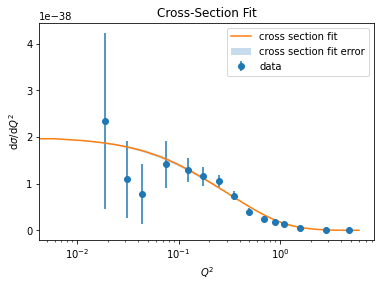

In [10]:
# draw data and fitted line
plt.errorbar(Q2_vals, xsec_trimmed, xsec_err_scaled, fmt="o", label="data")

Q2_span = pd.DataFrame(np.linspace(0, 6, 1000),columns=['Q2'])['Q2']
z = findZ(t_cut,t_0,Q2_span)
FA_fit = zExp_of_z(zExp_str_fortran,z,k_max,xsec_m.values)
xsec_fit = FA_to_xsec(Q2_span,FA_fit)
plt.plot(Q2_span, xsec_fit, label="fit")
plt.xscale('log')
plt.title('Cross-Section Fit')
plt.xlabel('$Q^2$')
plt.ylabel('d$\sigma$/d$Q^2$')

fit_line_error = []
for i in range(len(Q2_span)):
    grad_FA = grad(fortran_to_py(zExp_str_fortran),xsec_m.values,Q2_span.iloc[i],k_max)

    fa0_coeffs = pd.read_csv('xsec_conversion/bbba2005_fa0.csv',names=['Q2','FA0_coeff'])
    fa1_coeffs = pd.read_csv('xsec_conversion/bbba2005_fa1.csv',names=['Q2','FA1_coeff'])
    fa2_coeffs = pd.read_csv('xsec_conversion/bbba2005_fa2.csv',names=['Q2','FA2_coeff'])
    fa0_loc = get_bin(fa0_coeffs,'Q2',Q2_span.iloc[i])
    fa0_coeff = fa0_coeffs['FA0_coeff'][fa0_loc]
    fa1_loc = get_bin(fa1_coeffs,'Q2',Q2_span.iloc[i])
    fa1_coeff = fa1_coeffs['FA1_coeff'][fa1_loc]
    fa2_loc = get_bin(fa2_coeffs,'Q2',Q2_span.iloc[i])
    fa2_coeff = fa2_coeffs['FA2_coeff'][fa2_loc]

    dXsecdFA = const*(fa1_coeff+2*fa2_coeff*FA_fit.iloc[i])
    grad_xsec = dXsecdFA*grad_FA
    fit_line_error.append(np.sqrt(np.matmul(np.matmul(grad_xsec, xsec_m.covariance), grad_xsec)))
fit_lower_bound = [(xsec_fit[i]-fit_line_error[i]) for i in range(len(xsec_fit))]
fit_upper_bound = [(xsec_fit[i]+fit_line_error[i]) for i in range(len(xsec_fit))]
plt.fill_between(Q2_span,fit_lower_bound,fit_upper_bound,alpha=0.25)

plt.legend(['cross section fit','cross section fit error','data'])

In [ ]:
# draw data and fitted line
plt.errorbar(Q2_vals, xsec_trimmed, xsec_err_scaled, fmt="o", label="data")

Q2_span = pd.DataFrame(np.linspace(0, 6, 1000),columns=['Q2'])['Q2']
z = findZ(t_cut,t_0,Q2_span)
FA_fit = zExp_of_z(zExp_str_fortran,z,k_max,xsec_m.values)
xsec_fit = FA_to_xsec(Q2_span,FA_fit)
plt.plot(Q2_span, xsec_fit, label="fit")
plt.xscale('log')
plt.yscale('log')
plt.title('Cross-Section Fit')
plt.xlabel('$Q^2$')
plt.ylabel('d$\sigma$/d$Q^2$')

fit_line_error = []
for i in range(len(Q2_span)):
    grad_FA = grad(fortran_to_py(zExp_str_fortran),xsec_m.values,Q2_span.iloc[i],k_max)

    fa0_coeffs = pd.read_csv('xsec_conversion/bbba2005_fa0.csv',names=['Q2','FA0_coeff'])
    fa1_coeffs = pd.read_csv('xsec_conversion/bbba2005_fa1.csv',names=['Q2','FA1_coeff'])
    fa2_coeffs = pd.read_csv('xsec_conversion/bbba2005_fa2.csv',names=['Q2','FA2_coeff'])
    fa0_loc = get_bin(fa0_coeffs,'Q2',Q2_span.iloc[i])
    fa0_coeff = fa0_coeffs['FA0_coeff'][fa0_loc]
    fa1_loc = get_bin(fa1_coeffs,'Q2',Q2_span.iloc[i])
    fa1_coeff = fa1_coeffs['FA1_coeff'][fa1_loc]
    fa2_loc = get_bin(fa2_coeffs,'Q2',Q2_span.iloc[i])
    fa2_coeff = fa2_coeffs['FA2_coeff'][fa2_loc]

    dXsecdFA = const*(fa1_coeff+2*fa2_coeff*FA_fit.iloc[i])
    grad_xsec = dXsecdFA*grad_FA
    fit_line_error.append(np.sqrt(np.matmul(np.matmul(grad_xsec, xsec_m.covariance), grad_xsec)))
fit_lower_bound = [(xsec_fit[i]-fit_line_error[i]) for i in range(len(xsec_fit))]
fit_upper_bound = [(xsec_fit[i]+fit_line_error[i]) for i in range(len(xsec_fit))]
plt.fill_between(Q2_span,fit_lower_bound,fit_upper_bound,alpha=0.25)

plt.legend(['cross section fit','cross section fit error','data'])

In [ ]:
Q2_tests = pd.DataFrame([0, 0.1, 0.5, 1.0, 2.5, 5, 10],columns=['Q2'])['Q2']
z_tests = findZ(t_cut,t_0,Q2_tests)
FA_tests = zExp_of_z(zExp_str_fortran,z_tests,k_max,FA_m.values)
xsec_tests = FA_to_xsec(Q2_tests,FA_tests)

print('Q2 =', Q2_tests)
print('z =', z_tests)
print('FA =', FA_tests)
print('xsec =', xsec_tests)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=dab8a3a7-8300-449a-9e65-b218971948b2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>